# Import Cruft

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap

import jax
import jax.numpy as jnp
from jax import random
import blackjax


# Performing calculations on all extraction steps

The Swindle and Olson dataset did not include duration of extraction steps.  We impute the durations by fitting to Figure 1 of Shuster and Weiss.  However, this figure only goes up to 750C, so some extraction steps do not have imputed durations.

Some calculations must be performed relative to all of the data (e.g. fractional release denominator).  Other calculations must be performed without the high-temperature extraction data to avoid NaNs polluting our Bayesian code.  We begin with calculations on the entire dataset.

In [2]:
entire_df = pd.read_csv('data/nakhla1_parsed_fitted.csv')[["Temp", "39Ar", "std_39Ar", "seconds_per_extraction_step"]]
total_39Ar = entire_df['39Ar'].sum()
entire_df['ΔF'] = entire_df['39Ar'] / total_39Ar          # fractional release per extraction step
entire_df['F'] = entire_df['ΔF'].cumsum()                 # cumulative release
entire_df['R'] = 1 - entire_df['F'].shift(fill_value=0)   # % of 39Ar left
entire_df['T_K'] = entire_df['Temp'] + 273.15

# Fechtig & Kalbitzer (1966) piece‑wise solution for a sphere
def y_from_F(F):
    if F < 0 or F > 1:
        return np.nan
    if F < 0.85:                     # low‑loss branch: F = (6/√π)√y – 3y
        a = 6/np.sqrt(np.pi)
        disc = a*a - 12*F
        s = (a - np.sqrt(disc)) / 6          # choose the small root
        y = s**2
    else:                           # high‑loss branch: F = 1 – 6/π² e^(‑π²y)
        y = -(1/np.pi**2) * np.log((1 - F)*np.pi**2 / 6)
        # the last extraction step is invalid and accounts for >15% of the 39Ar
        # so we should never use this branch of the approximation
        raise ValueError("should never be used")
    return y

entire_df['y'] = entire_df['F'].apply(y_from_F)  # get dimensionless time aka "diffusion progress"


In [3]:
entire_df.head()

,Temp,39Ar,std_39Ar,seconds_per_extraction_step,ΔF,F,R,T_K,y
0,250,0.8243,0.08243,23.023992,0.003378,0.003378,1.000000,523.15,9.972739e-07
1,275,0.9584,0.09584,117.189533,0.003927,0.007305,0.996622,548.15,4.674091e-06
2,300,1.2445,0.12445,274.907229,0.005099,0.012404,0.992695,573.15,1.351423e-05
3,325,2.2650,0.22650,1507.021186,0.009281,0.021685,0.987596,598.15,4.150695e-05
4,350,4.8860,0.48860,2167.500405,0.020020,0.041705,0.978315,623.15,1.551885e-04


# Creating filtered dataset

The dataset columns will define a log-likelihood, so we now create a filtered df to only extraction steps with imputed durations (those performed at <750C).

In [4]:
filtered_df = entire_df.dropna()

We can now plot the reproduction of Figure 1.

/var/folders/j_/gtf27dt106j4lt576pm77g_40000gn/T/ipykernel_82402/1677384801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['lnD/rho^2'] = np.log(entire_df['y'].diff().shift(-1) / entire_df['seconds_per_extraction_step'])  # from y=D/\rho^22 * Δt
/var/folders/j_/gtf27dt106j4lt576pm77g_40000gn/T/ipykernel_82402/1677384801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['10K*invT'] = 10**4 / filtered_df['T_K']


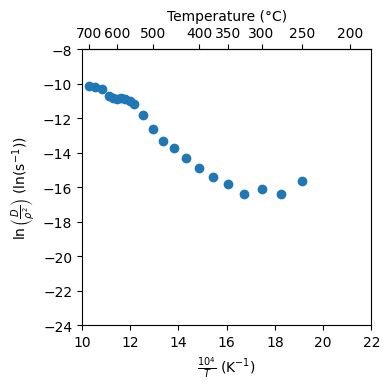

In [5]:
filtered_df['lnD/rho^2'] = np.log(entire_df['y'].diff().shift(-1) / entire_df['seconds_per_extraction_step'])  # from y=D/\rho^22 * Δt
filtered_df['10K*invT'] = 10**4 / filtered_df['T_K']
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(filtered_df['10K*invT'], filtered_df['lnD/rho^2'])
plt.xlabel(r'$\frac{10^4}{T}$ (K$^{-1}$)')
plt.ylabel(r'$\ln\left(\frac{D}{\rho^2}\right)$ (ln(s$^{-1}$))')
ax2 = plt.gca().secondary_xaxis('top', functions=(lambda x: 1e4/x - 273.15, lambda x: 1e4/(x + 273.15)))
ax2.set_xlabel('Temperature (°C)')
ax2.set_xticks([700, 600, 500, 400, 350, 300, 250, 200])
ax.set_ylim(-24, -8)
ax.set_xlim(10, 22)
plt.tight_layout()
plt.show()

And we can now set up the tensors that will be used to fit the multiple domain model.

In [6]:
temps_K = filtered_df["T_K"].values
f_obs = filtered_df["ΔF"].values
sigma_obs = filtered_df["std_39Ar"].values / total_39Ar + 1e-12
dt = filtered_df["seconds_per_extraction_step"].values

# Fitting the Multiple Domain Model

We define our priors and hyperparameters first.

In [7]:
# Number of domains
k = 2

# priors
# Ea prior : N(117, 5)
# logD0_r2 prior : N(5.7, 0.5)
# means are HRD values from Shuster + Weiss
# stds are half the reported one-sided margin of error.
Ea_prior_mean = 117
Ea_prior_std = 10
logD0_r2_prior_mean = 5.7
logD0_r2_prior_std = 2.0
dirichlet_alphas = jnp.array([1.5] * k)

# MCMC Hyperparameters
num_warmup = 1000
num_samples = 1000
num_chains = 100
key = random.PRNGKey(0)
chain_keys = random.split(key, num_chains)


Now we define our log-likelihood function.  `fractional_release` inverts `y_from_F` in a JAX-friendly way.  Although unlikely to ever occur, we impose a penalty on negative activation energies to only get physically realizable fits.

In [8]:
def stick_breaking(phi_raw):
    """Convert (k-1,) unconstrained to k-simplex via stick-breaking."""
    phi_raw = jnp.asarray(phi_raw)
    probs = jax.nn.sigmoid(phi_raw)  # (k-1,)
    
    # Compute cumprod of (1-probs) with a 1.0 prepended
    one_minus_probs = 1.0 - probs
    remaining = jnp.concatenate([jnp.array([1.0]), jnp.cumprod(one_minus_probs)])
    
    # Final proportions: probs * remaining, plus final remainder
    phi_pieces = probs * remaining[:-1]
    phi = jnp.concatenate([phi_pieces, remaining[-1:]])
    return phi

def fractional_release(y):
    """
    Fechtig & Kalbitzer (1966) piece-wise approximation for a sphere.

      y ≡ ∫ D(t) dt / r²

    Valid for 0 ≤ y ≲ 10 (covers the entire laboratory step-heating range).
    """
    y = jnp.asarray(y)
    F_short = 6 * jnp.sqrt(y / jnp.pi) - 3 * y
    F_long  = 1 - (6 / jnp.pi**2) * jnp.exp(-jnp.pi**2 * y)
    F = jnp.where(y < 0.3, F_short, F_long)
    return jnp.clip(F, 0.0, 1.0)        # numerical safety


def log_prob(params):
    Ea, logD0_r2, phi_raw = params["Ea"], params["logD0_r2"], params["phi_raw"]
    phi  = stick_breaking(phi_raw)
    D_r2 = jnp.exp(logD0_r2)[:, None]            # (k,1)

    R, T = 8.314, temps_K[None, :]               # J mol⁻¹ K⁻¹
    y_inc = D_r2 * jnp.exp(-Ea[:, None]*1e3 / (R*T)) * dt   # (k,m)
    y_cum = jnp.cumsum(y_inc, axis=1)
    Fcum  = fractional_release(y_cum)            # (k,m)
    dF    = jnp.diff(Fcum, axis=1,
                     prepend=jnp.zeros((k,1)))   # (k,m)

    # --- mix domains ---
    dF_mix      = (phi @ dF)                     # (m,)
    F_final_mix = (phi @ Fcum[..., -1])          # scalar < 1
    f_pred      = dF_mix / F_final_mix           # normalised spectrum

    ll = jnp.sum(
        -0.5 * ((f_obs - f_pred)/sigma_obs)**2
        - jnp.log(sigma_obs)
        - 0.5 * jnp.log(2*jnp.pi)
    )
    prior = jnp.sum(
        -0.5 * (Ea - Ea_prior_mean)**2 / Ea_prior_std**2
        -0.5 * (logD0_r2 - logD0_r2_prior_mean)**2 / logD0_r2_prior_std**2
        -0.5 * (dirichlet_alphas - 1) * jnp.log(phi)
    )
    penalty_for_negative_ea = jnp.sum(jnp.where(Ea < 0, -1e6, 0))
    return ll + prior + penalty_for_negative_ea

# Warming up with Blackjax

This window adaptation should mimic Stan's HMC implementation.  `step_sizes` should be nonzero.  This takes about ~2 minutes to run on an M3 Macbook.

In [9]:
def init_params(key):
    """Updated init_params function with (k-1) phi_raw dimensions."""
    
    # draw the three domain-level vectors
    subk_Ea, subk_logD0r2, subk_phi = random.split(key, 3)

    Ea        = random.normal(subk_Ea,       (k,)) * Ea_prior_std + Ea_prior_mean
    logD0_r2  = random.normal(subk_logD0r2, (k,)) * logD0_r2_prior_std + logD0_r2_prior_mean
    phi_raw   = random.normal(subk_phi,      (k-1,))  # Changed from (k,) to (k-1,)

    return {"Ea": Ea, "logD0_r2": logD0_r2, "phi_raw": phi_raw}



init_params_batch = jax.vmap(init_params)(chain_keys)

# -------------------------------------------------
# warm-up for each chain: return arrays only
# -------------------------------------------------
def warmup_one_chain(key, init_p):
    warm  = blackjax.window_adaptation(blackjax.nuts, log_prob)
    (state, tuned), _ = warm.run(key, init_p, num_steps=num_warmup)
    return state, tuned["step_size"], tuned["inverse_mass_matrix"]

# vmap it across many chains
states, step_sizes, inv_mats = jax.vmap(warmup_one_chain)(chain_keys,
                                                          init_params_batch)
step_sizes

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [ ]:
min(step_sizes), max(step_sizes)

# Running MCMC

Now we get the samples.  This takes several minutes running on an M3 Macbook.

In [ ]:
# shapes:
#   states.position["Ea"]        ->  (chains, k)
#   step_sizes                   ->  (chains,)
#   inv_mats["Ea"]               ->  (chains, k)   (diagonal form)

def run_chain(state, keys, step_size, inv_mass):
    """Return (final_state, positions_over_time)."""
    # build kernel *once* for this chain
    kernel = blackjax.nuts(log_prob, step_size, inv_mass)

    def one_step(carry, key):
        st = carry
        st, _ = kernel.step(key, st)
        return st, st.position          # collect sample

    final_state, positions = jax.lax.scan(one_step,  state, keys)
    return final_state, positions       # positions: pytree (time,k)

# vmapped over the chain axis
run_all_chains = jax.vmap(run_chain,
                          in_axes=(0, 0, 0, 0))   # chain-wise

# ------------------------------------------------------------
# 2.  Execute – single JIT compile
# -----------------------------------------------------------

# Make per-chain key-stacks:  (chains, num_samples, 2)
sample_keys = jax.vmap(
    lambda k: random.split(k, num_samples)
)(chain_keys)

final_states, trace_positions = run_all_chains(
    states,               # (chains, …)
    sample_keys,          # (chains, num_samples, 2)
    step_sizes,           # (chains,)
    inv_mats,             # pytree (chains, …)
)

# trace_positions is a pytree whose leaves are (chains, time, k)
# swap axes so time is first:  (time, chains, k)
trace_positions = jax.tree.map(lambda x: jnp.swapaxes(x, 0, 1),
                               trace_positions)

# ------------------------------------------------------------
# 3.  Prepend warm-up end-positions
# ------------------------------------------------------------
warmup_pos = states.position                  # pytree (chains,k)

full_samples = {
    p: jnp.concatenate([
            warmup_pos[p][None, ...],         # shape (1, chains, k)
            trace_positions[p]                # shape (time, chains, k)
        ],
        axis=0                               # time axis
    )
    for p in warmup_pos.keys()               # 'Ea', 'logD0_r2', 'phi_raw'
}
full_samples

In [ ]:
fs_np = jax.device_get(full_samples)          # dict of np.ndarray
fs_np["phi"] = jax.vmap(jax.vmap(stick_breaking))(fs_np["phi_raw"]) # vmap over chains and MCMC step, shape (timesteps, chains, domains)

final_phis = fs_np["phi"][-1]  # shape (chains, domains)

# For each chain, find which domain has larger final phi
larger_domain = np.argmax(final_phis, axis=1)  # shape (chains,)

# Create permutation array that puts larger domain first
perm = np.stack([larger_domain, 1-larger_domain], axis=1)  # shape (chains, 2)

# Permute all arrays
for key in fs_np:
    if key != "phi_raw":
        # Reshape to (time, chains, domains)
        # Then permute domains according to perm array
        fs_np[key] = np.take_along_axis(
            fs_np[key],
            perm[None, :, :],  # broadcast perm across time dimension
            axis=2
        )


# dimensions
T, C, k = fs_np["Ea"].shape     # time, chains, domains

def logprob_from_arrays(Ea, logD0_r2, phi_raw):
    return log_prob({"Ea": Ea,
                     "logD0_r2": logD0_r2,
                     "phi_raw":  phi_raw})

# vmap over chains, then over time:  (T, C) array
ll = jax.vmap(
        jax.vmap(logprob_from_arrays,
                 in_axes=(0,0,0)),      # iterate over chains
        in_axes=(0,0,0)                 # iterate over time
     )(full_samples["Ea"], full_samples["logD0_r2"], full_samples["phi_raw"])

ll = jax.device_get(ll)                 # move to NumPy for plotting

# ------------------------------------------------------------------
# 2) Plot traces (Ea, logD0_r2, phi) with faint strokes
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharex=True)
plot_items = [("Ea",        "Ea  (kJ/mol)"),
              ("logD0_r2",  "log D₀ / ρ²"),
              ("phi",       "Proportion φ")]

cmap   = get_cmap("tab10")     # high-contrast palette
alpha  = 0.1                  # faint lines
lw     = 0.4

for ax, (key, title) in zip(axes, plot_items):
    for d in range(k):
        colour = cmap(d)
        traces = fs_np[key][:, :, d]          # (time, chain)
        for c in range(C):
            ax.plot(traces[:, c], color=colour, lw=lw, alpha=alpha)
    ax.set_title(title)

# 4th subplot: log-likelihood
axes[3].plot(-ll, color="gray", alpha=0.2, lw=lw)
axes[3].set_yscale('log')
axes[3].set_title("Negative Log-likelihood")

# domain-colour legend
handles = [Line2D([0], [0],
                  color=cmap(d), lw=2)
           for d in range(k)]
labels  = [f"Domain {d+1}" for d in range(k)]

fig.legend(handles=handles,
           labels=labels,          # <-- add this line
           loc="upper center",
           ncol=k,
           frameon=False,
           bbox_to_anchor=(0.5, 1.05))

fig.tight_layout()
plt.show()
# 

In [ ]:
plt.hist(fs_np["phi"][-1, :, 0], bins=30)

In [ ]:
# Get the last phi values from each chain
last_phis = fs_np["phi"][-1]  # shape: (chains, k)

# Find chains where phi is close to [0,1] or [1,0]
is_extreme = np.logical_or(
    np.all(np.isclose(last_phis, [0, 1], atol=0.1), axis=1),
    np.all(np.isclose(last_phis, [1, 0], atol=0.1), axis=1)
)

# Get log-likelihoods for those chains
extreme_lls = -ll[-1, is_extreme]  # Note: ll is already negative

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(extreme_lls, bins=20)
plt.xlabel("Negative Log-likelihood")
plt.ylabel("Count")
plt.title("Log-likelihood Distribution for Extreme Phi Values")
plt.show()


In [ ]:
ll.shape

In [ ]:
is_extreme

In [ ]:
from turtle import st
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Assumed to exist in the workspace
#   • fractional_release(y)   – Fechtig-Kalbitzer function
#   • temps_K                 – (m,)  extraction temperatures [K]
#   • dt                      – (m,)  duration of each step [s]
#   • f_obs, sigma_obs        – (m,)  incremental release + 1 σ
#   • full_samples            – dict with keys 'Ea','logD0_r2','phi_raw'
# ------------------------------------------------------------------

R = 8.314  # J mol⁻¹ K⁻¹

# ------------------------------------------------------------------
# 1) Last posterior draw from every chain  →  predicted spectra
# ------------------------------------------------------------------
last = {k: v[-1] for k, v in full_samples.items()}       # (chains,k)
phi  = jax.vmap(jax.vmap(stick_breaking))(last["phi_raw"])[:, -1, :]

EaJ  = last["Ea"] * 1e3                                  # (C,k)
Dr2  = jnp.exp(last["logD0_r2"])                         # (C,k)

y_inc = Dr2[..., None] * jnp.exp(-EaJ[..., None] / (R * temps_K)) * dt  # (C,k,m)
y_cum = jnp.cumsum(y_inc, axis=-1)                       # (C,k,m)
F_cum = fractional_release(y_cum)                        # (C,k,m)

dF   = jnp.diff(F_cum, axis=-1, prepend=jnp.zeros_like(F_cum[..., :1])) # (C,k,m)
Ffin = (phi * F_cum[..., -1]).sum(axis=1)[:, None]        # (C,1)
f_pred = (phi[..., None] * dF).sum(axis=1) / Ffin         # (C,m)

f_pred_np = jax.device_get(f_pred)                        # move to host

# ------------------------------------------------------------------
# 2) “Paper” single-domain reference: Ea=117 kJ mol⁻¹, ln(D0/ρ²)=5.7
# ------------------------------------------------------------------
Ea_ref          = 117.0                    # kJ mol⁻¹
logDr2_ref_ln   = 5.7
Dr2_ref         = jnp.exp(logDr2_ref_ln)

y_inc_ref  = Dr2_ref * jnp.exp(-Ea_ref*1e3 / (R * temps_K)) * dt
y_cum_ref  = jnp.cumsum(y_inc_ref)
F_cum_ref  = fractional_release(y_cum_ref[None, :])[0]
dF_ref     = jnp.diff(F_cum_ref, prepend=0.0)
f_pred_ref = dF_ref / F_cum_ref[-1]

f_pred_ref_np = jax.device_get(f_pred_ref)

# ------------------------------------------------------------------
# 3) Plot
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4))

final_cumulative_release_with_extraction_time = filtered_df["F"].values[-1]
scaled_f_obs = f_obs / final_cumulative_release_with_extraction_time

# observed + 2σ band
ax.fill_between(temps_K - 273.15,
                scaled_f_obs - 2*sigma_obs,
                scaled_f_obs + 2*sigma_obs,
                color='grey', alpha=0.3, label='Observed ±2σ')
ax.plot(temps_K - 273.15, scaled_f_obs, color='k', lw=2, label='Observed f_obs')

# posterior trajectories (blue, faint)
for fp in f_pred_np:
    ax.plot(temps_K - 273.15, fp, color='tab:blue', alpha=0.06, lw=0.6)

# reference curve (orange)
ax.plot(temps_K - 273.15, f_pred_ref_np,
        color='tab:orange', lw=2,
        label='Paper: Ea=117 kJ/mol, ln(D₀/ρ²)=5.7')

ax.set_xlabel('Extraction temperature (°C)')
ax.set_ylabel('Fraction of $^{39}$Ar released per step')
ax.set_title('Observed vs. Predicted Release Spectra')
ax.legend(frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
y_cum_ref.shape

In [ ]:
F_cum_ref.shape

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(temps_K - 273.15, dt, 'k-', lw=2)
ax.set_xlabel('Extraction temperature (°C)')
ax.set_ylabel('Step duration (s)')
ax.set_title('Temperature vs. Step Duration')
plt.tight_layout()
plt.show()
